# [NTDS'18] milestone 2: network models
[ntds'18]: https://github.com/mdeff/ntds_2018

[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: 44
* Students: Nikolai Orgland, Silvan Stettler, Yann Morize, Diego Debruyn
* Dataset: Swiss Federal Council

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* In the first part, you cannot import any other library than we imported. In the second part, you are allowed to import any library you want.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The purpose of this milestone is to explore various random network models, analyse their properties and compare them to your network. In the first part of the milestone you will implement two random graph models and try to fit them to your network. In this part you are not allowed to use any additional package. In the second part of the milestone you will choose a third random graph model that you think shares some properties with your network. You will be allowed to use additional packages to construct this network, but you must explain your network choice. Finally, make your code as clean as possible, and keep your textual answers short.

## Part 0

Import the adjacency matrix of your graph that you constructed in milestone 1, as well as the number of nodes and edges of your network.

In [1]:
import numpy as np

# We have several binary matrices created using different thresholds
filenames = ["adjacency_0.1", "adjacency_0.3", "adjacency_0.5", "adjacency_0.7", "adjacency_0.9"]

adjacencies_binary =  [np.load(file+".npy") for file in filenames]
n_nodes =  np.asarray([a.shape[0] for a in adjacencies_binary])
n_edges =  np.asarray([np.sum(a)/2 for a in adjacencies_binary])
thresholds = np.linspace(0.1, 0.9, 5)

## Part 1

**For the computation of this part of the milestone you are only allowed to use the packages that have been imported in the cell below.**

In [2]:
%matplotlib inline

import random

import pandas as pd
import matplotlib.pyplot as plt
import scipy

### Question 1

Create a function that constructs an Erdős–Rényi graph.

In [3]:
def erdos_renyi(n, p, seed=None):
    """Create an instance from the Erdos-Renyi graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    p: float
        Edge probability. A number between 0 and 1.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    np.random.seed(seed)
    G = np.zeros((n,n))
    
    for i in range(n):
        for j in range(i,n):
            if i != j:
                r = random.random()
                if r <= p:
                    # Probability p that nodes are connected
                    G[i,j] = 1
                else:
                    continue
            else:
                # Nodes are not connected with themselves, leave the zeros
                continue
    adjacency = G + np.transpose(G)
    
    return adjacency

Text(0.5,1.05,'Erdos-Renyi (5, 0.6)')

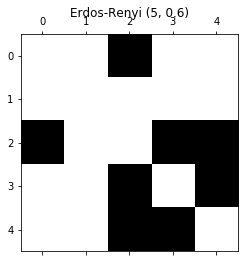

In [4]:
er = erdos_renyi(5, 0.6, 9765)
plt.spy(er)
plt.title('Erdos-Renyi (5, 0.6)')

Text(0.5,1.05,'Erdos-Renyi (10, 0.4)')

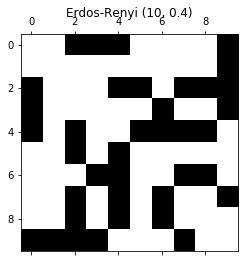

In [5]:
er = erdos_renyi(10, 0.4, 7648)
plt.spy(er)
plt.title('Erdos-Renyi (10, 0.4)')

### Question 2

Use the function to create a random Erdos-Renyi graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

In [6]:
# Take probability based on maximum possible number of edges and observed edges
p_link = n_edges/(n_nodes*(n_nodes-1)/2)
er_CN = [erdos_renyi(n, p) for n,p in zip(n_nodes,p_link)]
L_er = [(np.count_nonzero(er))/2 for er in er_CN]
n_nodes_er = [er.shape[0] for er in er_CN]
L = n_edges

for i in range(len(er_CN)):
    print("The number of links in the Erdos-Renyi graph with p = {0:.3f} is {1:.0f}".format(p_link[i], L_er[i]))
    print("The number of links in our graph with threshold {0:.1f} is {1:.0f}\n".format(thresholds[i], L[i]))

The number of links in the Erdos-Renyi graph with p = 0.806 is 15980
The number of links in our graph with threshold 0.1 is 16030

The number of links in the Erdos-Renyi graph with p = 0.634 is 12620
The number of links in our graph with threshold 0.3 is 12618

The number of links in the Erdos-Renyi graph with p = 0.376 is 7466
The number of links in our graph with threshold 0.5 is 7485

The number of links in the Erdos-Renyi graph with p = 0.236 is 4691
The number of links in our graph with threshold 0.7 is 4697

The number of links in the Erdos-Renyi graph with p = 0.179 is 3559
The number of links in our graph with threshold 0.9 is 3568



**By using the formula of the course for the expected number of links in a random graph
\begin{equation}
L =p\frac{N(N-1)}{2}  
\end{equation} 
We can isolate $p$ and calculate it with the number of links $N$ and the number of edges $L$ for our different thresholded adjacency matrix. We can then use this value $p$ and the number of nodes $N$ to create an Erdos-Renyi graph which will have (in average) the same number of edges as our adjacency**


### Question 3

Create a function that constructs a Barabási-Albert graph.

In [7]:
def barabasi_albert(n, m, m0, seed=None):
    """Create an instance from the Barabasi-Albert graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    m: int
        Number of edges to attach from a new node to existing nodes.
    m0: int
        Number of initial nodes
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    if m > m0:
        return print("The inital number of nodes is too small")
    
    np.random.seed(seed)
    
    # initalizing the graph
    G = np.zeros((n,n))
    nodes = np.arange(m0)
    

    # connecting the initial m0 nodes together
    for i in range(m0):
        G[i,i+1] = 1
    
    for j in range(m0,n):
    
        # count degrees of existing nodes
        k_i = np.sum(G[nodes, :],axis = 1)
        
        # Nodes to which no edge exists yet
        available_nodes = nodes
    
        # add m links to new node
        rand_nb = np.random.rand(m)  

        for i in range(m):
            # compute probability of connection with each available node
            p = k_i[available_nodes]/np.sum(k_i[available_nodes])
            
            # compute cumulated probability array which can be used to classifiy a generated random number
            p_cum = np.cumsum(p)
            
            target_index = min(np.argwhere(p_cum >= rand_nb[i]))
            target_node = available_nodes[target_index]
            available_nodes = np.delete(available_nodes, target_index)
    
            # We connect the selected target node
            G[j,target_node] = 1
        
        # Finally, we add the new node to our existing node list
        nodes = np.append(nodes, j)
    
    adjacency = G + np.transpose(G)
    
    
    return adjacency


Text(0.5,1.05,'Barabasi-Albert (5, 1)')

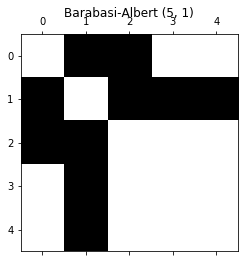

In [8]:
ba = barabasi_albert(5, 1, 2, 9087)
plt.spy(ba)
plt.title('Barabasi-Albert (5, 1)')

Text(0.5,1.05,'Barabasi-Albert (10, 2)')

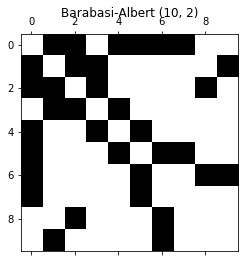

In [9]:
ba = barabasi_albert(10, 2, 2, 8708)
plt.spy(ba)
plt.title('Barabasi-Albert (10, 2)')

### Question 4

Use the function to create a random Barabási-Albert graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

**The number of edges $w$ in a random Barabási-Albert graph with $n$ nodes and is given by
\begin{equation}
w = m_0 + (n-m_0)m 
\end{equation}
Thus, if a given number of edges $w^*$ should be contained in the graph (similar to the number of edges in our network), we need to find the integer solution to the above equations with the constraint $m \leq m_0$.
For the networks that were created with the thresholds 0.1 and 0.3, the number of edges is $>10000$ and it is impossible to find a corresponding $m$ and $m_0$ that result in a similar number of edges.**

In [10]:
# These m0 and m correspond to a final number of edges similar to the real network with thresholds 0.5, 0.7 and 0.9
ba_param = [(48,48),(50,31),(32,21)]

ba_CN = [barabasi_albert(200, param[1], param[0]) for param in ba_param]
n_nodes_ba_CN = [ba.shape[0] for ba in ba_CN]
n_edges_ba_CN = [np.sum(ba)/2 for ba in ba_CN]

#plt.spy(ba_CN)
#plt.title('Barabasi-Albert Conseil National (10, 2)')
for i in range(len(ba_CN)):
    print ("Simulation of a BA model with {0} inital nodes, {1} links per new node"
           .format(ba_param[i][0], ba_param[i][1]))
    print ("The number of nodes with this BA model: %d " % n_nodes_ba_CN[i])
    print ("The number of edges with this BA model: %d\n" % n_edges_ba_CN[i])


Simulation of a BA model with 48 inital nodes, 48 links per new node
The number of nodes with this BA model: 200 
The number of edges with this BA model: 7344

Simulation of a BA model with 50 inital nodes, 31 links per new node
The number of nodes with this BA model: 200 
The number of edges with this BA model: 4700

Simulation of a BA model with 32 inital nodes, 21 links per new node
The number of nodes with this BA model: 200 
The number of edges with this BA model: 3560



**The corresponding $m_0$ and $m$ values for the thresholds 0.5, 0.7 and 0.9 were found with Wolfram Alpha and applying the constraint $m \leq m_0$. The obtained values were 48, 50, 32 for the inital number of nodes $m_0$ and 48, 31, 21 for the links per node $m$ respectively**

### Question 5

Compare the number of edges in all three networks (your real network, the Erdős–Rényi network, and the Barabási-Albert netowk).

In [11]:
for i in range(len(thresholds)):
    print ("\nReal network created with threshold {0:.1f}: Nodes: {1} Edges: {2:.0f}"
           .format(thresholds[i],n_nodes[i], n_edges[i]))
    print ("Erdös-Rényi network                      Nodes: {0} Edges: {1:.0f}"
           .format(n_nodes_er[i], L_er[i]))
    
    # For thresholds 0.1 and 0.3, no equivalent BA network can be created
    if i > 1:
        print ("Barabási-Albert network                  Nodes: {0} Edges: {1:.0f}"
               .format(n_nodes_ba_CN[i-2], n_edges_ba_CN[i-2])) 



Real network created with threshold 0.1: Nodes: 200 Edges: 16030
Erdös-Rényi network                      Nodes: 200 Edges: 15980

Real network created with threshold 0.3: Nodes: 200 Edges: 12618
Erdös-Rényi network                      Nodes: 200 Edges: 12620

Real network created with threshold 0.5: Nodes: 200 Edges: 7485
Erdös-Rényi network                      Nodes: 200 Edges: 7466
Barabási-Albert network                  Nodes: 200 Edges: 7344

Real network created with threshold 0.7: Nodes: 200 Edges: 4697
Erdös-Rényi network                      Nodes: 200 Edges: 4691
Barabási-Albert network                  Nodes: 200 Edges: 4700

Real network created with threshold 0.9: Nodes: 200 Edges: 3568
Erdös-Rényi network                      Nodes: 200 Edges: 3559
Barabási-Albert network                  Nodes: 200 Edges: 3560


**As explained above, we were not able to to generate a Barabási-Albert network for the tresholds 0.1 and 0.3. For the other synthetic Erdös-Rényi and Barabási-Albert networks, we were able to find reasonable parameters that produced very similar amounts of edges than the real network. The observable differences in number of edges for the Erdös-Rényi model are due to the randomness in the network generation function. The differneces for the Barabási-Albert occur as as there were no combination of $m_0$ and $m$ that resulted in the exact same number of edges as for the real networks**

### Question 6

Implement a function that computes the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between two probability distributions.
We'll use it to compare the degree distributions of networks.

In [12]:
def kl_divergence(p, q):
    """Compute the KL divergence between probability distributions of degrees of two networks.
    
    Parameters
    ----------
    p: np.array
        Probability distribution of degrees of the 1st graph.
    q: np.array
        Probability distribution of degrees of the 2nd graph.
    
    Returns
    -------
    kl
        The KL divergence between the two distributions.
    """
    
    kl=np.dot(p,np.log(p/q))
    
    return kl

In [13]:
p_test = np.array([0.2, 0.2, 0.2, 0.4])
q_test = np.array([0.3, 0.3, 0.1, 0.3])
kl_divergence(p_test, q_test)

0.09151622184943572

### Question 7

Compare the degree distribution of your network to each of the two synthetic ones, in terms of KL divergence. **Hint:** Make sure you normalise your degree distributions to make them valid probability distributions.

In [14]:
def get_degree_distibution(adjacency, bins=None, laplace_smoothing=True, set_minmax=None):
    """"This function returns the degree distribution for a graph with adjacency matrix adjacency.
    In order to compute meaningful KL divergences, the degree axis is divided into intervals
    and an average degree per intervall is computed. Furthermore, Laplace smoothing can be enabled in order to avoid 
    zero frequencies for some intervals which is necessary for the computation of the KL divergence.
    
    Returns vector of interval midpoints (degrees), probability for node to have a degree inside a certain interval,
    average and extremas of the degree distirbution"""
    
    """ bins: number of intervalls between k_min and k_max
        set_minmax: The minimum and maximum of the k axis can optionally be chosen. Along with the bins argument,
        the sampling points can implicitly be chosen
        laplace_smoothing: enables additive laplace smoothing. One occurence of a degree inside a given interval is 
        added to the counts actually observed in the adjacency matrix. This avoids having zero probabilities in 
        certain intervals of k, thus avoiding problems when computing KL-Divergence. """
        
    k_i = np.sum(adjacency, axis=1)/2
    k_i.sort()
    k_freq, counts = np.unique(k_i, return_counts=True)
    
    if bins == None:
        return k_freq, counts/np.sum(counts), [np.mean(k_i), (min(k_i), max(k_i))]
    
    # Create sample intervalls
    if set_minmax == None:
        dk, h = np.linspace(min(k_freq), max(k_freq), bins+1, retstep=True)
    else:
        dk, h = np.linspace(set_minmax[0], set_minmax[1], bins+1, retstep=True)
    
    if dk[-1] < max(k_i):
        print("Warning: Chosen domain not wide enough")
    # Midpoints of the sampling intervals
    k_s = dk[1:] - h/2
    counts_s = []
    prev_idx = 0
    
    # Laplace smoothing to avoid zero frequencies
    if laplace_smoothing:
        alpha = 1;
        d = len(dk[1:])
    else:
        alpha = 0;
        d = 0;
        
    # Sample degree distribution
    for k in dk[1:]:
        idx_smaller = np.argwhere(k_freq <= k)
        if idx_smaller.size == 0:
            counts_s.append(alpha)
            continue
        else:
            idx = max(idx_smaller)+1
            idx = np.asscalar(idx)
            counts_s.append(np.sum(counts[prev_idx:idx])+alpha)
            prev_idx = idx
    # Normalize distribution
    counts_s = np.array(counts_s)/(sum(counts_s)+d*alpha)
    
    # Return mean, max and min of degree distribution
    stats = [np.mean(k_i), (min(k_i), max(k_i))]
    return k_s, counts_s, stats 

In [15]:
# Computation of normalized degree distributions
intervals = 66
# Degrees from 0 to 100 and apply smoothing to avoid non-zero frequencies 
k_minmax = (0,100)
smooth = True

# Degree distributions for real network, ER and BA corresponding to thresholds 0.3, 0.5, 0.7
deg_dist = [get_degree_distibution(adj_bin, bins=intervals,
                                laplace_smoothing=smooth, set_minmax=k_minmax) for adj_bin in adjacencies_binary[1:4]]
deg_dist_er = [get_degree_distibution(er, bins=intervals, 
                                laplace_smoothing=smooth, set_minmax=k_minmax) for er in er_CN[1:4]]
deg_dist_ba = [get_degree_distibution(ba, bins=intervals,
                                laplace_smoothing=smooth, set_minmax=k_minmax) for ba in ba_CN]

In [16]:
# Prepare iterables
k = []; p = []; k_er = []; p_er = []; k_ba = []; p_ba = []
for real, er, ba in zip(deg_dist, deg_dist_er, deg_dist_ba):
    k.append(real[0])
    p.append(real[1])
    k_er.append(er[0])
    p_er.append(er[1])
    k_ba.append(ba[0])
    p_ba.append(ba[1])


In [17]:
# Calculate Kullback-Leibler divergences
kl_er = [kl_divergence(weights, weights_er) for weights, weights_er in zip(p, p_er)]
kl_ba = [kl_divergence(weights,weights_ba) for weights, weights_ba in zip(p[1:3], p_ba[0:2])]

for i in range(3):
    print("\nKL-Divergence from the real network with threshold {0:.1f} to the ER network: {1:.3f}"
          .format(thresholds[i+1],kl_er[i]))
    if i > 0:
        print("KL-Divergence from the real network with threshold {0:.1f} to the BA network: {1:.3f}"
          .format(thresholds[i+1],kl_ba[i-1]))


KL-Divergence from the real network with threshold 0.3 to the ER network: 0.693

KL-Divergence from the real network with threshold 0.5 to the ER network: 0.127
KL-Divergence from the real network with threshold 0.5 to the BA network: 0.584

KL-Divergence from the real network with threshold 0.7 to the ER network: 1.259
KL-Divergence from the real network with threshold 0.7 to the BA network: 0.857


**When looking into our values of the KL-Divergence, we observe that only the degree distribution that ressembles to that of a ER or BA network is the real network with a treshold of 0.5. If we tried to approximate our degree distributions with either the ER or BA models, the highest information loss would occur for real networks with a threshold of 0.7. For a treshold value of 0.5, we observe intermediate values of information loss**

### Question 8

Plot the degree distribution historgrams for all three networks. Are they consistent with the KL divergence results? Explain.

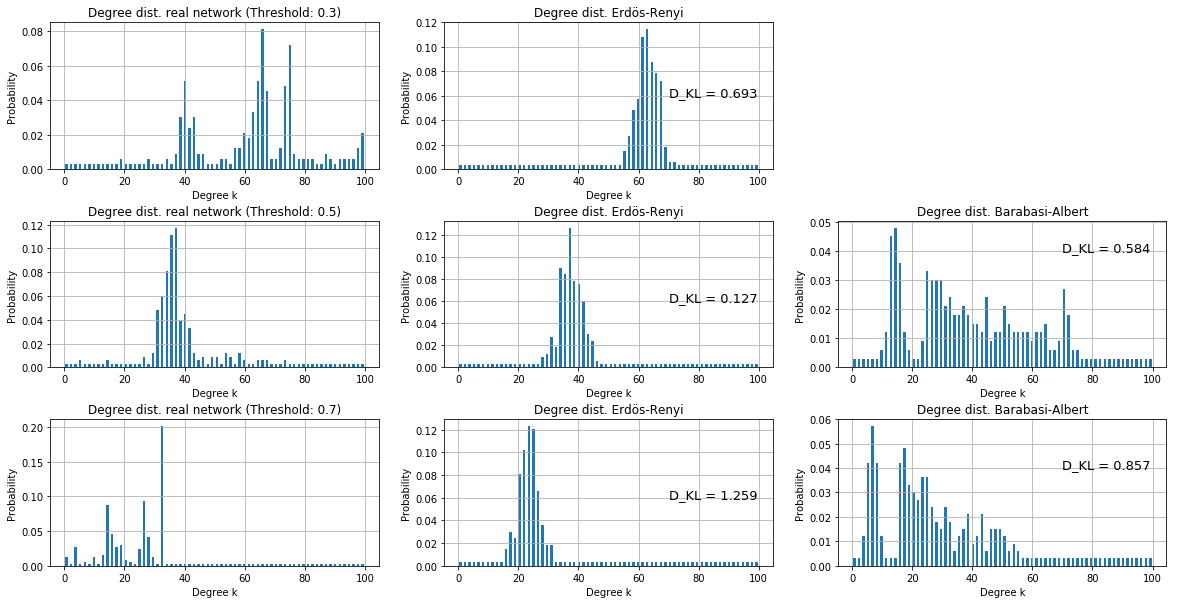

In [18]:
# Degree distributions of real network (thres. 0.3, 0.5, 0.7) and the equivalent ER and BA in the same row
plt.figure(figsize=(20, 10))
for i in range(3):
    plt.subplot(3,3,1+3*i)
    plt.bar(k[i], p[i])
    plt.grid(True)
    plt.xlabel("Degree k")
    plt.ylabel("Probability")
    plt.title("Degree dist. real network (Threshold: {0:.1f})".format(thresholds[i+1]))
    plt.subplot(3,3,2+3*i)
    plt.bar(k_er[i], p_er[i])
    plt.grid(True)
    plt.xlabel("Degree k")
    plt.ylabel("Probability")
    plt.title("Degree dist. Erdös-Renyi")
    plt.text(70,0.06,"D_KL = {0:.3f}".format(kl_er[i]), fontsize=13)
    if i > 0:
        plt.subplot(3,3,3+3*i)
        plt.bar(k_ba[i-1], p_ba[i-1])
        plt.grid(True)
        plt.xlabel("Degree k")
        plt.ylabel("Probability")
        plt.title("Degree dist. Barabasi-Albert")
        plt.text(70,0.04,"D_KL = {0:.3f}".format(kl_ba[i-1]), fontsize=13)
plt.subplots_adjust(hspace=0.35, wspace=0.2)

**From comparing the degree distributions, we can clearly conclude that the ER model is a better approximation of our real networks than the BA model. This is also consisent with the values of the KL-divergence which are significantly higher when computed for BA models (with respect to the real networks), than for the ER models. In short: More information is lost when we use BA to approximate our data than for using ER.**

### Question 9

Imagine you got equal degree distributions. Would that guarantee you got the same graph? Explain.

**No. The spatial distribution of nodes with the same degree is not reflected in the simple plots of the degreee distributions. For the same degree distribution, a graph might for example have a higher clustering coefficient as another graph with exactly the same degree distribution. Degree distribution only describes how many links there are but not how they are connected and therefore does not fully describe what is happening in a graph**

## Part 2

**You are allowed to use any additional library here (e.g., NetworkX, PyGSP, etc.).** Be careful not to include something here and use it in part 1!

In [19]:
import networkx as nx

### Question 10

Choose a random network model that fits you network well. Explain your choice. 

**Hint:** Check lecture notes for different network models and their properties. Your choice should be made based on at least one property you'd expect to be similar.

**The choice of a similar network is not straight-forward. Our network doesn't change in time and highly depends on the  chosen threshhold. Our network does not look like it is scale free, since we don't really see any nodes that are of a degree orders of magnitudes larger than the average degree. Neither do we have a significant number of nodes around low degrees. Yet, the degree distributions for all thresholds look more complex than a Poisson-like distribution. Considering that we are modelling a parliament with political parties it is reasonable that there is some kind of preferential attachment mechanism underlying our network.
Hence, we suspect that our network corresponds to the limiting case of the BA model in which there is no growth and only preferential attachment (presented as 'Model B' in the course). We expect a similar clustering coefficient. KL divergence will be assessed to compare degree distributions. A random network chosen among all network with n nodes and m links will also be computed for comparison purpose.**

### Question 11

Explain (in short) how the chosen model works.

**Model B start from N nodes without any link. At each step a new link is added between a randomly chosen node and a second one. The later is chosen with a probablity proportional to its degree. Thus, a large degree node is more likely to be the second one. This is similar to the 'normal' Barabasi-Albert model**

### Question 12

Create a random graph from that model, such that the number of nodes is the same as in your graph.

In [20]:
# Function that creates a given number of nodes and connects them with a preference one after the other. 
# The link probability is given by the Pi function such as in the normal BA model that includes growth
def preferential_attachment_graph(n, n_links, seed=None):
    """Based on the Barabasi-Albert graph, but without network growth. At each instance t, a link is added to a node
    out of n nodes in the network with preferential attachment"""
    
    if n_links > n*(n-1)/2:
        return print("The number of edges is larger than the maximum number of edges possible")
    
    np.random.seed(seed)
    G = np.zeros((n,n))
    nodes = np.arange(n)
    
    # Initial attachment probability (unconnected nodes have Pi(1) => equivalent to every node having one link)
    k_i = np.ones(n)
    fully_connected_nodes = []
    
    for t in range(n_links):
        rand_number = np.random.random(2)
        # Nodes that are already fully connected can be connected more
        k1 = np.delete(k_i, fully_connected_nodes)
        # Cum. probability to connect to any of the non-fully connected nodes
        p1 = np.cumsum(k1)/np.sum(k1)
        nodes_1 = np.delete(nodes, fully_connected_nodes)
        
        # Choose first node and remove node and neighbours temporarily from list
        node_1 = np.asscalar(nodes_1[min(np.argwhere(p1 >= rand_number[0]))])
        node_1_neighbours = np.nonzero(G[node_1,:])
        
        # Attachment probability for the remaining available nodes (Can't connect to itself and already connected nodes)
        excluded_nodes = np.append(node_1, node_1_neighbours)
        k2 = np.delete(k_i, excluded_nodes)
        p2 = np.cumsum(k2)/np.sum(k2)
        nodes_2 = np.delete(nodes, excluded_nodes)

        # Choose second node
        node_2 = np.asscalar(nodes_2[min(np.argwhere(p2 >= rand_number[1]))])
        # Connect them
        G[node_1, node_2] = 1
        G[node_2, node_1] = 1
        
        # Check if nodes are now fully connected
        if np.count_nonzero(G[node_1,:])>= n-1:
            fully_connected_nodes.append(node_1)
        if np.count_nonzero(G[node_2,:]) >= n-1:
            fully_connected_nodes.append(node_2)
            
        # Update degrees
        k_i[node_1] += 1
        k_i[node_2] += 1
    
    return G

# clustering coefficient functions from Milestone 1
def compute_clustering_coefficient(adjacency, node):
    Li=0
    
    #Counts the number of neighbours of 'node' 
    ki= np.count_nonzero(adjacency[node,:])
    
    #creates a vector with all the neighbours of 'node'
    idx_neighbour_nodes = np.nonzero(adjacency[node,:])                   
    idx_neighbour_nodes = list(idx_neighbour_nodes[0])                    
    
    #all the potential connexions between the neighbours of 'node'
    for i in range(len(idx_neighbour_nodes)):
        for j in range(i,len(idx_neighbour_nodes)): 
            #test if theses nodes are actually connected
            if adjacency[idx_neighbour_nodes[i],idx_neighbour_nodes[j]]>0:
                Li=Li+1
            else: continue
    
    if (ki == 0)|(ki == 1):
        clustering_coefficient=0
    else :
        clustering_coefficient= (2*Li)/(ki*(ki-1))

    return clustering_coefficient

def compute_avg_clustering_coefficient(adjacency):
    c_i = [compute_clustering_coefficient(adjacency, node) for node in range(200) ]
    c=np.mean(c_i)
    
    return c


In [21]:
# Create Model B graph and compute degree distribution
G_pref_attach = [preferential_attachment_graph(n, int(n_link)) for n,n_link in zip(n_nodes,n_edges)]
deg_dist_pref_attach = [get_degree_distibution(a_pref, bins=intervals,
                                laplace_smoothing=smooth, set_minmax=k_minmax) for a_pref in G_pref_attach[1:4]]

# Create random graph and compute degree distribution
G_random_graph= [nx.to_numpy_array(nx.gnm_random_graph(n,int(n_link))) for n,n_link in zip(n_nodes,n_edges)]
deg_dist_random_graph = [get_degree_distibution(a_pref, bins=intervals,
                                laplace_smoothing=smooth, set_minmax=k_minmax) for a_pref in G_random_graph[1:4]]

In [22]:
# Prepare iterables
k_pref = []; p_pref = []
for pref_attach in deg_dist_pref_attach:
    k_pref.append(pref_attach[0])
    p_pref.append(pref_attach[1])
    
k_rand = []; p_rand = []
for rand in deg_dist_random_graph:
    k_rand.append(rand[0])
    p_rand.append(rand[1])

In [23]:
# Calculate clustering coefficient and KL divergence
kl_pref = [kl_divergence(weights, weights_pref) for weights, weights_pref in zip(p, p_pref)]
kl_rand = [kl_divergence(weights, weights_rand) for weights, weights_rand in zip(p, p_rand)]


clustering_pref=[compute_avg_clustering_coefficient(adjancecy) for adjancecy in G_pref_attach[1:4]]
clustering_rand=[compute_avg_clustering_coefficient(adjancecy) for adjancecy in G_random_graph[1:4]]
clustering_net=[compute_avg_clustering_coefficient(adjancecy) for adjancecy in adjacencies_binary[1:4]]

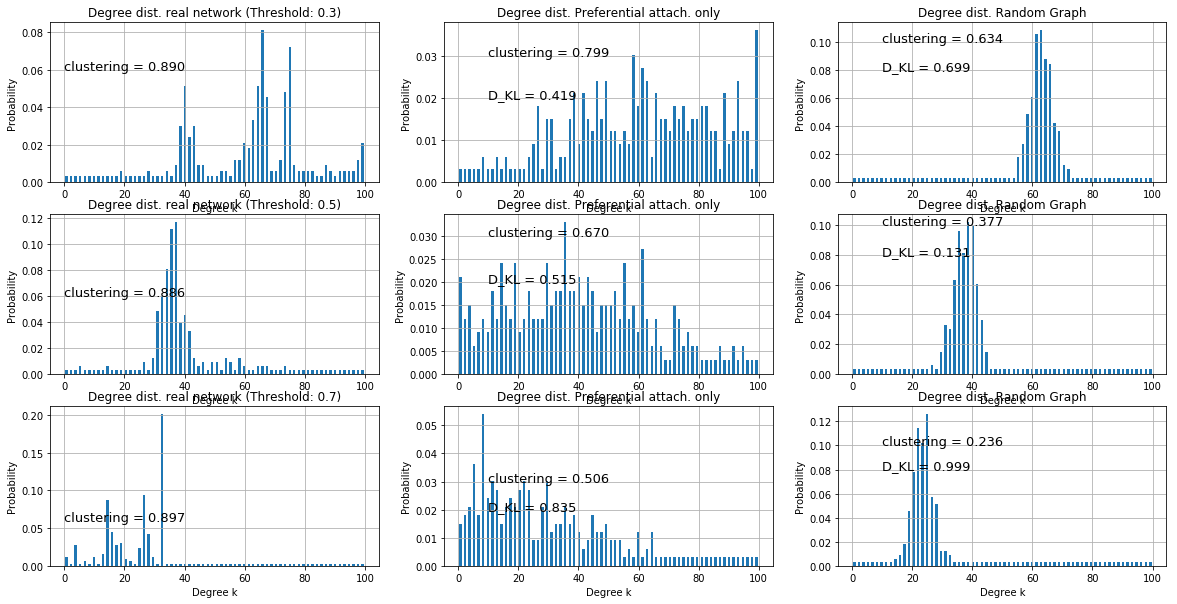

In [24]:
plt.figure(figsize=(20, 10))
for i in range(3):
    plt.subplot(3,3,1+3*i)
    plt.bar(k[i], p[i])
    plt.grid(True)
    plt.xlabel("Degree k")
    plt.ylabel("Probability")
    plt.title("Degree dist. real network (Threshold: {0:.1f})".format(thresholds[i+1]))
    plt.text(0,0.06,"clustering = {0:.3f}".format(clustering_net[i]), fontsize=13)
    
    plt.subplot(3,3,2+3*i)
    plt.bar(k_pref[i], p_pref[i])
    plt.grid(True)
    plt.xlabel("Degree k")
    plt.ylabel("Probability")
    plt.title("Degree dist. Preferential attach. only")
    plt.text(10,0.02,"D_KL = {0:.3f}".format(kl_pref[i]), fontsize=13)
    plt.text(10,0.03,"clustering = {0:.3f}".format(clustering_pref[i]), fontsize=13)
    
    plt.subplot(3,3,3+3*i)
    plt.bar(k_rand[i], p_rand[i])
    plt.grid(True)
    plt.xlabel("Degree k")
    plt.ylabel("Probability")
    plt.title("Degree dist. Random Graph")
    plt.text(10,0.08,"D_KL = {0:.3f}".format(kl_rand[i]), fontsize=13)
    plt.text(10,0.10,"clustering = {0:.3f}".format(clustering_rand[i]), fontsize=13)
    

### Question 13

Check the properties you expected to be similar, and compare to your network.

In [25]:
print('The clustering coefficients of our networks are (thresholds 0.3 0.5 0.7)')
print("{0:.2f} {1:.2f} {2:.2f}".format(clustering_net[0], clustering_net[1], clustering_net[2]))
print('The clustering coefficients of model B are')
print("{0:.2f} {1:.2f} {2:.2f}  ".format(clustering_pref[0], clustering_pref[1], clustering_pref[2]))
print('The clustering coefficients of the random network is')
print("{0:.2f} {1:.2f} {2:.2f}  ".format(clustering_rand[0], clustering_rand[1], clustering_rand[2]))

print('\nThe KL divergences for model B are')
print("{0:.2f} {1:.2f} {2:.2f}".format(kl_pref[0], kl_pref[1], kl_pref[2]))
print('The KL divergences for the random network are')
print("{0:.2f} {1:.2f} {2:.2f}  ".format(kl_rand[0], kl_rand[1], kl_rand[2]))

The clustering coefficients of our networks are (thresholds 0.3 0.5 0.7)
0.89 0.89 0.90
The clustering coefficients of model B are
0.80 0.67 0.51  
The clustering coefficients of the random network is
0.63 0.38 0.24  

The KL divergences for model B are
0.42 0.51 0.84
The KL divergences for the random network are
0.70 0.13 1.00  


Are the results what you expected? Explain.

**One can observe that the clustering coefficients are far bigger in our network then in a random netwok. Model B leads to closer clustering coefficients, mainly for small thresholds. But the graphs show that it is rather questionable whether a comparison of the three models is really insightful since they seem very different.
We tried several of the other models presented in class (for example the copying model) and we found that none of the random models presented really fit our case. This is not that surprising since the formation mechanism in our case is very specific (eg. political parties, no growth). In reality, nodes (councillors) preferentially attach not to high degree nodes but to nodes that share the same label as them (party).**


**One possible modellisation could consist of several Watts-Strogatz graphs, each representing one party for example. These could then be connected in a random fashion with a varying number of connecting links, resulting in one single graph. This could potentially capture the small-world properties observed without having high degree nodes**